In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install timm

In [ ]:
pip install torchviz


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import AutoModel, AutoTokenizer
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

from timm.data import resolve_data_config, create_transform

import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset

In [ ]:
from timm import create_model

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
    print("GPU Device Name:", torch.cuda.get_device_name(0))  # Assuming you have one GPU
else:
    print("GPU is not available.")
    device = torch.device("cpu")

GPU is available.
GPU Device Name: Tesla T4


### Meteorological Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Numerical Dataset Curation/Meteorological_Data.csv")

data.head()

# print(data.shape) #(8888, 22)



,DATETIME,Avg BRBG Total Cloud Cover [%],Avg CDOC Total Cloud Cover [%],Avg CDOC Thick Cloud Cover [%],Avg CDOC Thin Cloud Cover [%],Avg Sun Flag,Avg HCF Value,Avg Blue/Red_min,Avg Blue/Red_mid,Avg Blue/Red_max,...,Avg Zenith Angle [degrees],Avg Azimuth Angle [degrees],Avg Solar Eclipse Shading,Avg Tower Dew Point Temp [deg C],Avg Total Cloud Cover [%],Avg Opaque Cloud Cover [%],Avg Avg Wind Speed @ 6ft [m/s],Avg Precipitation [mm],Avg Moisture,Avg Albedo (CMP11)
0,2021-10-08 07:00:00,13.6667,36.8333,0.0000,36.8333,8.0,1.0367,0.9617,1.5850,3.1533,...,85.6866,101.5014,0,-1.1220,19.9667,10.4667,2.1028,0.0,0.0,0.2815
1,2021-10-08 08:00:00,56.1667,53.6667,26.0000,27.6667,3.5,1.0217,0.9333,1.4367,3.3533,...,74.7881,111.7340,0,-1.0662,61.8333,47.8667,0.8334,0.0,0.0,0.2330
2,2021-10-08 09:00:00,73.0000,66.3333,43.8333,22.5000,3.0,1.0517,0.9267,1.2800,2.6533,...,64.6156,123.3821,0,-0.2234,91.6167,77.2333,0.3564,0.0,0.0,0.2085
3,2021-10-08 10:00:00,38.8333,54.1667,18.0000,36.1667,3.0,1.0300,0.9367,1.4500,3.0850,...,55.8601,137.3319,0,0.5125,69.7667,39.2167,1.8796,0.0,0.0,0.2065
4,2021-10-08 11:00:00,62.3333,51.3333,25.1667,26.1667,3.0,1.0550,0.9850,1.2700,2.0233,...,49.3991,154.2831,0,-0.3288,91.8833,69.2000,2.6331,0.0,0.0,0.2002


In [ ]:
def preprocess_dataframe(df):
  """
  params:
  - df (dataframe): dataframe before preprocessing
  does:
  - Transform 'DATETIME' column from object to datetime format with renaming of column to timestamp.
  - Remove Outliers
  -Timestamp can be changed to index
  returns: Processed df (dataframe)
  """
  df['Timestamp'] = pd.to_datetime(df['DATETIME'])
  # df.set_index('Timestamp', inplace=True) # set timestamp as index
  df=df.drop(['DATETIME', 'Avg Solar Eclipse Shading'], axis=1) # Remove null columns
  df = df[df["Avg CDOC Total Cloud Cover [%]"] !=-99999 ] # remove outliers
  return df

df=preprocess_dataframe(data)
df.head()

cols_to_keep = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Opaque Cloud Cover [%]','Avg Blue/Red_min','Avg Global CMP22 (vent/cor) [W/m^2]','Avg BRBG Total Cloud Cover [%]','Avg Azimuth Angle [degrees]','Avg Albedo (CMP11)','Avg Tower Dew Point Temp [deg C]','Avg Total Cloud Cover [%]','Timestamp']
numeric_df=df.loc[:, cols_to_keep]
numeric_df = numeric_df.drop_duplicates(subset='Timestamp', keep='first')
numeric_df.head()

# numeric_df.shape #(8788, 11)

,Avg Zenith Angle [degrees],Avg Sun Flag,Avg Opaque Cloud Cover [%],Avg Blue/Red_min,Avg Global CMP22 (vent/cor) [W/m^2],Avg BRBG Total Cloud Cover [%],Avg Azimuth Angle [degrees],Avg Albedo (CMP11),Avg Tower Dew Point Temp [deg C],Avg Total Cloud Cover [%],Timestamp
0,85.6866,8.0,10.4667,0.9617,63.8407,13.6667,101.5014,0.2815,-1.1220,19.9667,2021-10-08 07:00:00
1,74.7881,3.5,47.8667,0.9333,176.1522,56.1667,111.7340,0.2330,-1.0662,61.8333,2021-10-08 08:00:00
2,64.6156,3.0,77.2333,0.9267,361.7695,73.0000,123.3821,0.2085,-0.2234,91.6167,2021-10-08 09:00:00
3,55.8601,3.0,39.2167,0.9367,582.2481,38.8333,137.3319,0.2065,0.5125,69.7667,2021-10-08 10:00:00
4,49.3991,3.0,69.2000,0.9850,632.4995,62.3333,154.2831,0.2002,-0.3288,91.8833,2021-10-08 11:00:00


## Image Dataset

In [ ]:
# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/Image Dataset Curation/Image_Dataset_Final.csv")

# print(df.shape)

df = df.drop_duplicates(keep='first')

df['datetime'] = pd.to_datetime(df['datetime'])

# Drop rows with missing values
#df = df.dropna(subset=['image_path', 'Avg Global CMP22 (vent/cor) [W/m^2]'])

df.head()

# print(df.shape) #(7189, 3)


,image_path,datetime,Avg Global CMP22 (vent/cor) [W/m^2]
0,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 07:00:00,63.8407
1,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 08:00:00,176.1522
2,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 09:00:00,361.7695
3,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 10:00:00,582.2481
4,/content/drive/MyDrive/Image Dataset Curation/...,2021-10-08 11:00:00,632.4995


In [ ]:
df_final = pd.merge(df, numeric_df, left_on='datetime', right_on='Timestamp',how='left')

df_final.head()
# df_final.drop(columns=['Timestamp'], inplace=True)
df_final.shape #(7189, 14)
df_final.drop(columns=['Timestamp','Avg Global CMP22 (vent/cor) [W/m^2]_y'], inplace=True)

df_final.rename(columns={'Avg Global CMP22 (vent/cor) [W/m^2]_x':'Avg Global CMP22 (vent/cor) [W/m^2]'},inplace=True)

df_final.shape #(7189, 13)

(7189, 12)

In [ ]:
df_final.columns

Index(['image_path', 'datetime', 'Avg Global CMP22 (vent/cor) [W/m^2]',
       'Avg Zenith Angle [degrees]', 'Avg Sun Flag',
       'Avg Opaque Cloud Cover [%]', 'Avg Blue/Red_min',
       'Avg BRBG Total Cloud Cover [%]', 'Avg Azimuth Angle [degrees]',
       'Avg Albedo (CMP11)', 'Avg Tower Dew Point Temp [deg C]',
       'Avg Total Cloud Cover [%]'],
      dtype='object')

## MultiInputModel

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from sklearn.preprocessing import StandardScaler





In [ ]:
# Custom dataset class

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None,scaler=None):
        self.dataframe = dataframe
        self.transform = transform
        self.scaler = scaler

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        img = Image.open(img_path).convert('RGB')

        # Scaling the image
        if self.transform:
            img = self.transform(img)

        metadata_columns = self.dataframe.columns.drop(['image_path', 'Avg Global CMP22 (vent/cor) [W/m^2]', 'datetime'])

        metadata = self.dataframe.iloc[idx][metadata_columns].values.astype(np.float32)
        if self.scaler:
            metadata = self.scaler.transform(metadata.reshape(1, -1))

        # The change is here: Flattening the transformed metadata to 1D
        metadata = torch.tensor(metadata[0], dtype=torch.float32)

        target = torch.tensor(float(self.dataframe.iloc[idx]['Avg Global CMP22 (vent/cor) [W/m^2]']), dtype=torch.float32)

        return img, metadata, target




        target = torch.tensor(float(self.dataframe.iloc[idx]['Avg Global CMP22 (vent/cor) [W/m^2]']), dtype=torch.float32)

        return img, torch.tensor(metadata, dtype=torch.float32), target


In [ ]:
class MultiModalModel(nn.Module):
    def __init__(self, num_metadata_features):
        super(MultiModalModel, self).__init__()

        # Image branch (Inception V4)
        self.cnn = timm.create_model('inception_v4', pretrained=True)
        in_features = self.cnn.last_linear.in_features
        self.cnn.last_linear = nn.Identity()

        # Metadata branch
        self.metadata_fc = nn.Sequential(
            nn.Linear(num_metadata_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Combined layer
        self.combined_fc = nn.Sequential(
            nn.Linear(in_features + 64, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )


    def forward(self, image, metadata):
        image_features = self.cnn(image)

        # Ensure that the image_features tensor is 4D
        if image_features.dim() == 2:
            # If the output is 2D (batch size, features), no need to pool
            image_features = image_features.view(image_features.size(0), -1)
        else:
            # If the output is 4D, apply adaptive_avg_pool2d
            image_features = nn.functional.adaptive_avg_pool2d(image_features, (1, 1)).view(image_features.size(0), -1)

        metadata_features = self.metadata_fc(metadata)

        combined_features = torch.cat((image_features, metadata_features), dim=1)
        output = self.combined_fc(combined_features)
        return output


## For visualization only

In [ ]:
import torch
from torch.autograd import Variable

image_sample = Variable(torch.rand(1, 3, 224, 224))  # Batch size 1
metadata_sample = Variable(torch.rand(1, 9))        # Batch size 1, 9 features

model = MultiModalModel(num_metadata_features=9)  # Adjust the number of metadata features
model.eval()
output = model(image_sample, metadata_sample)

from torchviz import make_dot

make_dot(output, params=dict(list(model.named_parameters()) + [('image', image_sample), ('metadata', metadata_sample)])).render("model_graph", format="png")


'model_graph.png'

In [ ]:
Image Input ----> Inception V4 Block ----\
                                          \
                                           >--- Feature Concatenation ---> Combined Layers ---> Output
                                          /
Metadata Input --> Metadata Layers ------/


In [ ]:
from graphviz import Digraph

dot = Digraph(comment='The MultiModal Model')

# Adding nodes
dot.node('A', 'Image Input')
dot.node('B', 'Inception V4 Block')
dot.node('C', 'Metadata Input')
dot.node('D', 'Metadata Processing Layers')
dot.node('E', 'Feature Concatenation')
dot.node('F', 'Combined Layers')
dot.node('G', 'Output')

# Adding edges
dot.edges(['AB', 'BC', 'DE', 'EF', 'FG'])
dot.edge('C', 'D', constraint='false')

# Render the graph to a file (e.g., in PNG format)
dot.render('multi_modal_model', format='png', cleanup=True)


'multi_modal_model.png'

In [ ]:
# Adjusting the node label from 'Metadata' to 'Meteorological Data'

dot = Digraph(comment='The MultiModal Model')

# Adding nodes
dot.node('A', 'Image Input')
dot.node('B', 'Inception V4 Block')
dot.node('C', 'Meteorological Data Input')
dot.node('D', 'Meteorological Data Processing Layers')
dot.node('E', 'Feature Concatenation')
dot.node('F', 'Combined Layers')
dot.node('G', 'Output')

# Adding edges to create a two-branch structure
dot.edge('A', 'B')  # Image Input to Inception V4 Block
dot.edge('B', 'E')  # Inception V4 Block to Feature Concatenation

dot.edge('C', 'D')  # Meteorological Data Input to Meteorological Data Processing Layers
dot.edge('D', 'E')  # Meteorological Data Processing Layers to Feature Concatenation

# Continuing from Feature Concatenation
dot.edges(['EF', 'FG'])

# Render the graph to a file (e.g., in PNG format)
file_path = 'multi_modal_model_meteorological_data'
dot.render(file_path, format='png', cleanup=True)

file_path + '.png'  # Return the path to the rendered image


'multi_modal_model_meteorological_data.png'

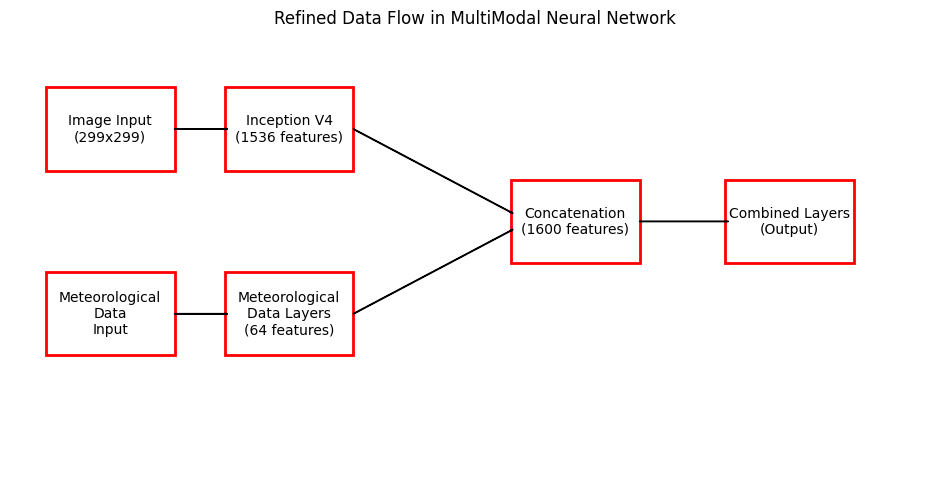

In [ ]:
# Function to create a diagram with improved layout and spacing, ensuring text and arrows are well-placed
def create_refined_data_flow_diagram():
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define rectangle positions and sizes
    rect_positions = {
        "image_input": (0.05, 0.7, 0.18, 0.18),
        "inception_v4": (0.3, 0.7, 0.18, 0.18),
        "metadata_input": (0.05, 0.3, 0.18, 0.18),
        "metadata_fc": (0.3, 0.3, 0.18, 0.18),
        "concatenation": (0.7, 0.5, 0.18, 0.18),
        "combined_fc": (1.0, 0.5, 0.18, 0.18)
    }

    # Create rectangles for different components of the model
    for key, (x, y, width, height) in rect_positions.items():
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Add text labels within rectangles
    ax.text(0.05 + 0.09, 0.7 + 0.09, 'Image Input\n(299x299)', fontsize=10, ha='center', va='center')
    ax.text(0.3 + 0.09, 0.7 + 0.09, 'Inception V4\n(1536 features)', fontsize=10, ha='center', va='center')
    ax.text(0.05 + 0.09, 0.3 + 0.09, 'Meteorological\nData\nInput', fontsize=10, ha='center', va='center')
    ax.text(0.3 + 0.09, 0.3 + 0.09, 'Meteorological\nData Layers\n(64 features)', fontsize=10, ha='center', va='center')
    ax.text(0.7 + 0.09, 0.5 + 0.09, 'Concatenation\n(1600 features)', fontsize=10, ha='center', va='center')
    ax.text(1.0 + 0.09, 0.5 + 0.09, 'Combined Layers\n(Output)', fontsize=10, ha='center', va='center')

    # Draw arrows with adjusted positions
    ax.arrow(0.23, 0.79, 0.07, 0, fc='k', ec='k')
    ax.arrow(0.48, 0.79, 0.22, -0.18, fc='k', ec='k')
    ax.arrow(0.23, 0.39, 0.07, 0, fc='k', ec='k')
    ax.arrow(0.48, 0.39, 0.22, 0.18, fc='k', ec='k')
    ax.arrow(0.88, 0.59, 0.12, 0, fc='k', ec='k')

    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.axis('off')

    plt.title('Refined Data Flow in MultiModal Neural Network')
    plt.show()

create_refined_data_flow_diagram()


In [ ]:
# Device configuration - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# df_final = pd.read_csv('your_dataset.csv')
df_final['datetime'] = pd.to_datetime(df_final['datetime'])
df_final = df_final.sort_values(by='datetime')

train_percentage = 0.8
train_index = int(train_percentage * len(df_final))
train_df = df_final[:train_index]
val_df = df_final[train_index:]

metadata_scaler = StandardScaler().fit(train_df.drop(['image_path', 'Avg Global CMP22 (vent/cor) [W/m^2]', 'datetime'], axis=1))

# Instantiate a pre-trained Inception V4 model to resolve data configuration
model = timm.create_model('inception_v4', pretrained=True)
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

# Create datasets
train_dataset = CustomDataset(train_df, transform=transform, scaler=metadata_scaler)
val_dataset = CustomDataset(val_df, transform=transform, scaler=metadata_scaler)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=UserWarning)

model = MultiModalModel(num_metadata_features=train_df.drop(['image_path', 'Avg Global CMP22 (vent/cor) [W/m^2]', 'datetime'], axis=1).shape[1])


train_losses = []
val_losses = []

# Enable GPU if available
model = model.to(device)

# Define a loss function. Here we use Mean Squared Error Loss for a regression task
criterion = nn.MSELoss()

# Define an optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early stopping parameters
early_stop_threshold = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
no_improve_epochs = 0  # Counter for epochs without improvement

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, metadata, targets in train_loader:
        # print(f"Images shape: {images.shape}")  # Expected: [N, C, H, W] #Images shape: torch.Size([32, 3, 299, 299])
        # print(f"Metadata shape: {metadata.shape}") #Metadata shape: torch.Size([32, 9])

        images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, metadata, targets in val_loader:
            images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_threshold:
            print(f"Stopping early at epoch {epoch + 1}")
            break


Epoch 1/20, Training Loss: 172833.8867, Validation Loss: 161298.0151
Epoch 2/20, Training Loss: 85789.0822, Validation Loss: 109434.3010
Epoch 3/20, Training Loss: 77295.5687, Validation Loss: 107308.3488
Epoch 4/20, Training Loss: 77303.7726, Validation Loss: 108528.2685
Epoch 5/20, Training Loss: 77260.9873, Validation Loss: 107101.2321
Epoch 6/20, Training Loss: 77208.5898, Validation Loss: 107501.2778
Epoch 7/20, Training Loss: 77123.0344, Validation Loss: 108523.3663
Epoch 8/20, Training Loss: 76992.5589, Validation Loss: 107341.8736
Stopping early at epoch 8


In [ ]:
# Check gradients after training
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.grad}")

Streaming output truncated to the last 5000 lines.
         ...,

         [[-1.0020e-01]],

         [[ 4.8812e-04]],

         [[-9.1797e-07]]],


        [[[ 7.9203e-03]],

         [[-1.8154e-02]],

         [[-4.0848e-04]],

         ...,

         [[-2.5010e-02]],

         [[-5.0942e-04]],

         [[-1.0744e-05]]],


        ...,


        [[[ 1.7065e-03]],

         [[-8.1344e-03]],

         [[-2.6969e-04]],

         ...,

         [[-3.6843e-02]],

         [[ 1.7026e-03]],

         [[ 2.2202e-05]]],


        [[[ 1.2635e-02]],

         [[ 2.6845e-02]],

         [[-2.1924e-03]],

         ...,

         [[ 1.6827e-01]],

         [[ 1.6051e-04]],

         [[-5.0125e-04]]],


        [[[-2.9861e-03]],

         [[-1.1381e-01]],

         [[-2.2631e-03]],

         ...,

         [[-3.2547e-01]],

         [[-2.8106e-03]],

         [[-3.8670e-04]]]], device='cuda:0')
cnn.features.19.branch3.1.bn.weight: tensor([ 1.2726e-01, -1.4116e-02,  7.4497e-02, -2.5687e-02,  3.0938

In [ ]:
train_losses

[172833.8866970486,
 85789.08224826389,
 77295.56868489583,
 77303.77259114584,
 77260.98732638889,
 77208.58984375,
 77123.03435329862,
 76992.55889756944]

In [ ]:
val_losses

[161298.01510416667,
 109434.30104166667,
 107308.34878472223,
 108528.26848958334,
 107101.23211805556,
 107501.27777777778,
 108523.36631944444,
 107341.8736111111]

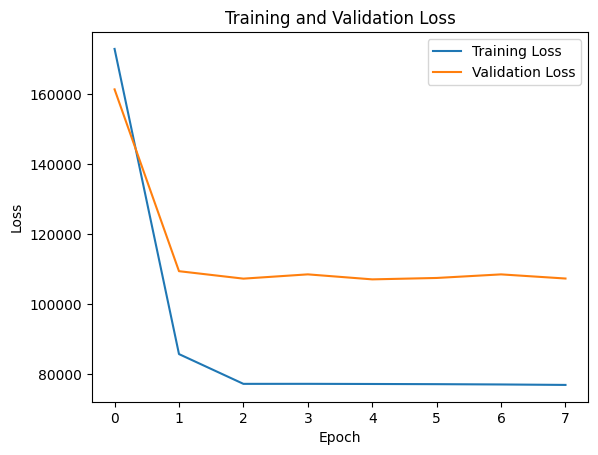

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the plot to Google Drive
save_path = '//content/drive/MyDrive/Forecasting Models/MultiInput Model/MultiModal/training_loss_curve.png'
plt.savefig(save_path)

plt.show()

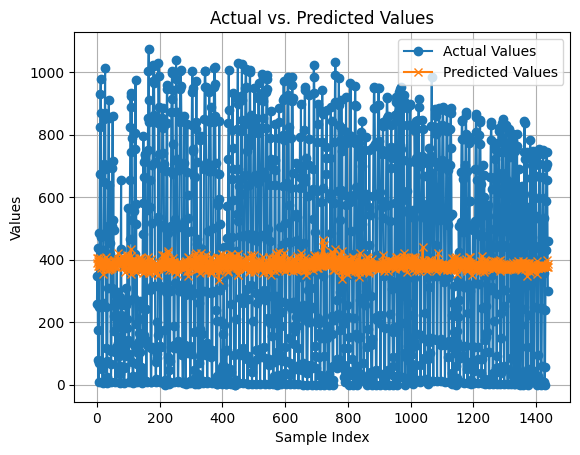

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


model.eval()
predictions = []
actual_values = []

with torch.no_grad():
    for images, metadata, targets in val_loader:
        images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
        outputs = model(images, metadata)  # Pass both images and metadata to the model
        predictions.extend(outputs.cpu().numpy())
        actual_values.extend(targets.cpu().numpy())

# Convert the lists to NumPy arrays
predictions = np.array(predictions)
actual_values = np.array(actual_values)

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' and 'actual_values' are NumPy arrays
# Make sure they have the same shape and represent the same samples

# Create an array of indices (e.g., for x-axis)
indices = np.arange(len(predictions))

# Line plot of actual values and predicted values
plt.plot(indices, actual_values, label='Actual Values', marker='o')
plt.plot(indices, predictions, label='Predicted Values', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)


# Save the plot to Google Drive
save_path = '/content/drive/MyDrive/Forecasting Models/MultiInput Model/MultiModal/actual_vs_predicted.png'
plt.savefig(save_path)


plt.show()

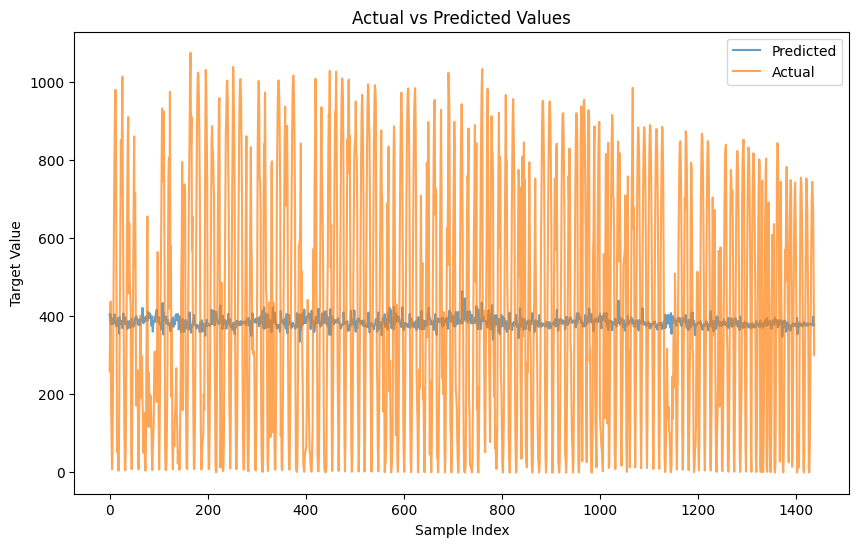

In [ ]:
model.eval()

predictions = []
actual_values = []
with torch.no_grad():
  for images, metadata, targets in val_loader:
    images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
    outputs = model(images, metadata)
    predictions.extend(outputs.cpu().numpy())
    actual_values.extend(targets.cpu().numpy())
import numpy as np

predictions = np.array(predictions)
actual_values = np.array(actual_values)
import matplotlib.pyplot as plt

# Assuming predictions and actual_values are 1-D arrays of the same length
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.plot(actual_values, label='Actual', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


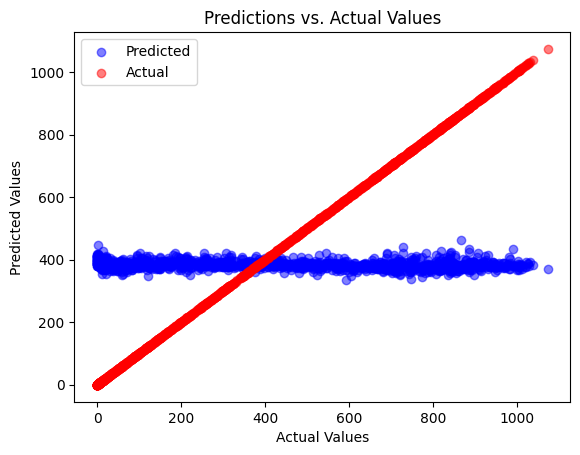

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have actual_values and predictions as NumPy arrays or lists
# You can replace these with your actual data

# Scatter plot with different colors
plt.scatter(actual_values, predictions, c='blue', label='Predicted', alpha=0.5)
plt.scatter(actual_values, actual_values, c='red', label='Actual', alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actual Values')

# Add a legend to distinguish between actual and predicted values
plt.legend()

# Save the plot to Google Drive
save_path = '/content/drive/MyDrive/Forecasting Models/MultiInput Model/scatter_plot_ActualVsPredicted.png'
plt.savefig(save_path)

plt.show()

In [ ]:
# # Save the entire model (including architecture, parameters, and optimizer state)
# torch.save({
#     'epoch': num_epochs,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': loss,
# }, '/content/drive/MyDrive/Forecasting Models/MultiInput Model/inception_v4.pth')

In [ ]:
#R2
from sklearn.metrics import r2_score

score = r2_score(actual_values, predictions)

print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.875.


In [ ]:
from sklearn.metrics import mean_absolute_error as mae
k = mae(predictions, actual_values)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     291.42245


In [ ]:
from sklearn import metrics

In [ ]:
# RMSE
print(np.sqrt(metrics.mean_squared_error(predictions, actual_values)))

329.4331
